# Аналитика новой стратегии

## Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

sns.set_style("darkgrid")

In [9]:
names = ['spread', 'start_buy_price', 'start_sell_price', 'end_buy_price', 'end_sell_price', 'start_time', 'end_time', 'ticker', 'buy_exchange', 'sell_exchange']
data = pd.read_csv('Datasets/arbitrage_data.tsv', names=names)

data['start_time'] = data['start_time'].apply(lambda x: datetime.fromtimestamp(x))
data['end_time'] = data['end_time'].apply(lambda x: datetime.fromtimestamp(x))
data['total_time'] = data['end_time'] - data['start_time']
data['total_time'] = data['total_time'].apply(lambda x: x.total_seconds())

data['buy_price_differnce'] = data['end_buy_price'] - data['start_buy_price']
data['sell_price_differnce'] = data['start_sell_price'] - data['end_sell_price']
data.head()

,spread,start_buy_price,start_sell_price,end_buy_price,end_sell_price,start_time,end_time,ticker,buy_exchange,sell_exchange,total_time,buy_price_differnce,sell_price_differnce
0,42.334,0.02975,0.05100,0.02268,0.02276,2022-11-01 00:00:00,2022-11-23 04:01:00,MDT/USDT,binance,mexc,1915260.0,-0.00707,0.02824
1,1.500,0.02266,0.02300,0.02262,0.02275,2022-11-23 04:07:00,2022-11-23 04:07:00,MDT/USDT,binance,mexc,0.0,-0.00004,0.00025
2,2.080,0.02263,0.02310,0.02263,0.02270,2022-11-23 04:13:00,2022-11-23 04:13:00,MDT/USDT,binance,mexc,0.0,0.00000,0.00040
3,1.190,0.02263,0.02290,0.02263,0.02280,2022-11-23 04:16:00,2022-11-23 04:16:00,MDT/USDT,binance,mexc,0.0,0.00000,0.00010
4,1.433,0.02281,0.02309,0.02294,0.02309,2022-11-23 07:04:00,2022-11-23 07:11:00,MDT/USDT,binance,mexc,420.0,0.00013,0.00000


In [10]:
data['bad_for_new_strategy_buy'] = data['buy_price_differnce'].apply(lambda x: x < 0)
data['bad_for_new_strategy_sell'] = data['sell_price_differnce'].apply(lambda x: x < 0)

In [11]:
data['bad_color_new_strategy_but'] = data.apply(lambda x: 'red' if x['bad_for_new_strategy_buy'] == True else \
                               'blue', axis=1)

data['bad_color_new_strategy_sell'] = data.apply(lambda x: 'red' if x['bad_for_new_strategy_sell'] == True else \
                               'blue', axis=1)

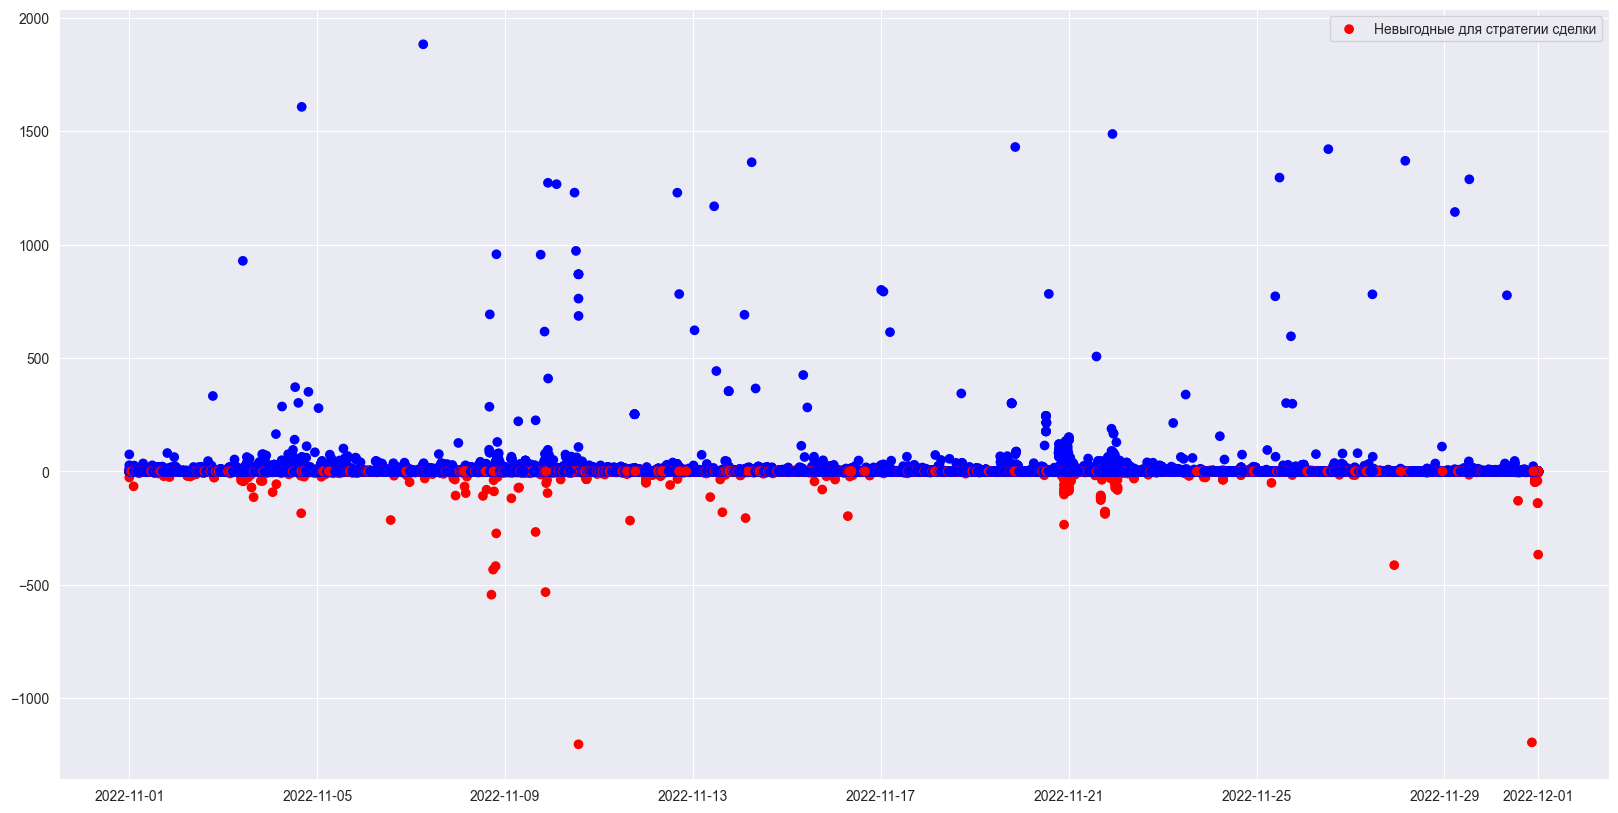

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(data["start_time"], data['buy_price_differnce'], color=data['bad_color_new_strategy_but'])
plt.legend(['Невыгодные для стратегии сделки'])

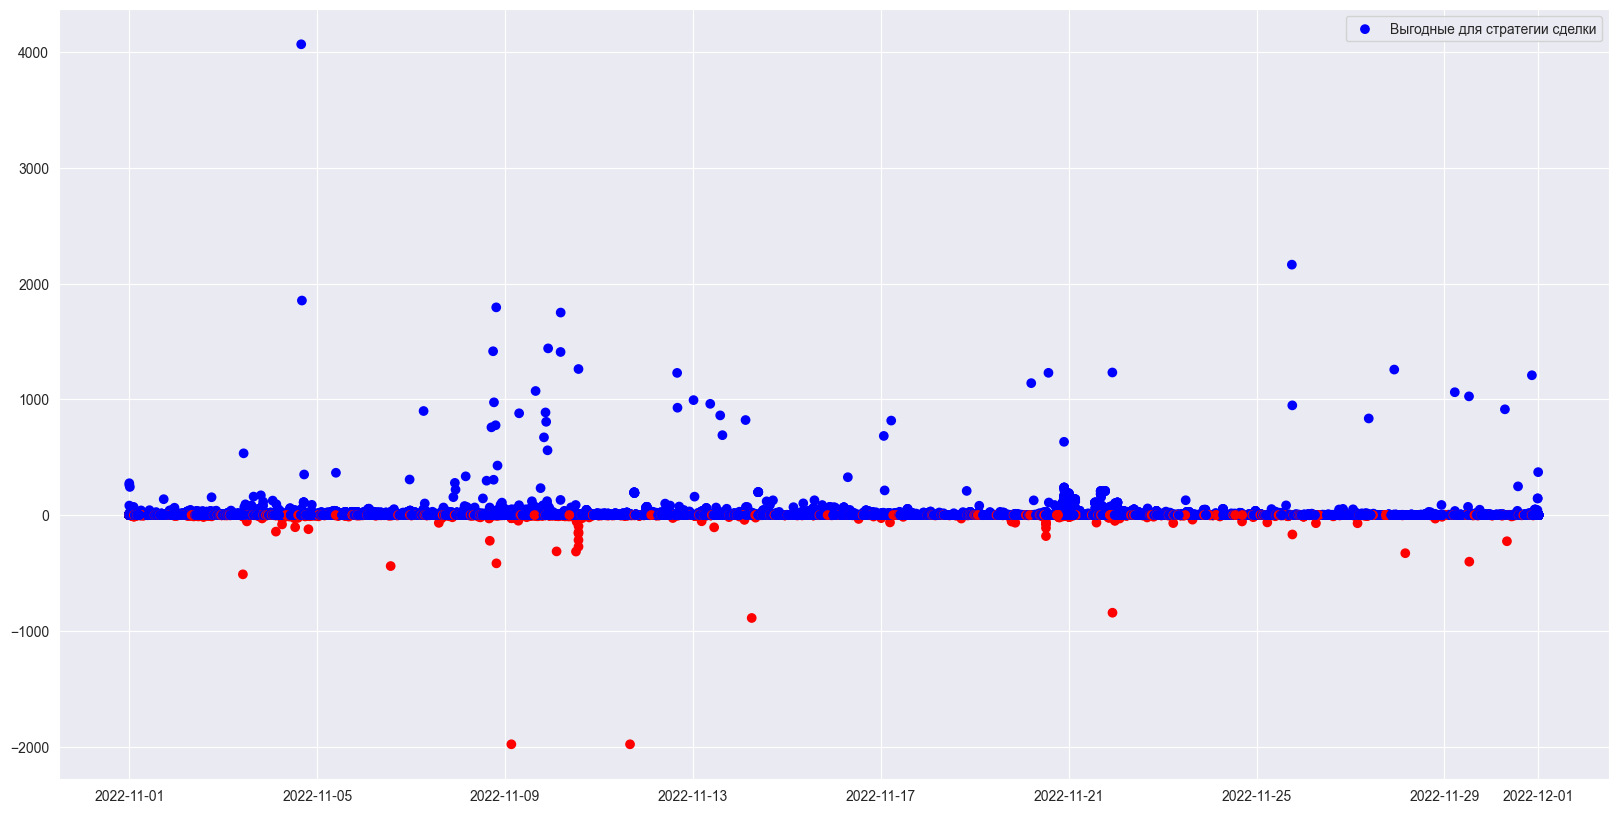

In [13]:
plt.figure(figsize=(20, 10))
plt.scatter(data["start_time"], data['sell_price_differnce'], color=data['bad_color_new_strategy_sell'])
plt.legend(['Выгодные для стратегии сделки'])

In [14]:
data.loc[data['bad_for_new_strategy_buy'] == False]['spread'].count() / data['spread'].count() * 100

85.02756213128033

In [15]:
data.loc[data['bad_for_new_strategy_sell'] == False]['spread'].count() / data['spread'].count() * 100

86.71170410057746

In [16]:
data['traded_for'] = data['ticker'].apply(lambda x: x.split('/')[1] == 'USDT')

In [20]:
new_data = data.loc[(data['traded_for'] == True) & (data['total_time'] > 120) & (data['spread'] <= 50)]

In [21]:
def long_and_short_token(x):
    long_sell = 0
    short_sell = 0
    if x['start_buy_price'] != 0:
        long_buy = 100 / x['start_buy_price']
        long_sell = long_buy * x['end_buy_price'] - 100
        
    if x['end_sell_price'] != 0:
        short_buy = 100 / x['end_sell_price']
        short_sell = long_buy * x['start_sell_price'] - 100
    
    return long_sell + short_sell

In [22]:
facts = []
for _ in range(1000):
    index = np.random.choice(new_data.index, size=1000, replace=False)
    s = new_data.loc[index].apply(lambda x: long_and_short_token(x), axis=1).sum()
    facts.append(s)
facts.sort()
print(f'from {int(facts[24])} to {int(facts[-25])}')

from 2101 to 3048
